In [1]:
from DataParser import DataParser
import numpy as np
import scipy.sparse as sps
from sklearn.model_selection import KFold

from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from SimpleEvaluator import evaluator
from Base.Evaluation.Evaluator import EvaluatorHoldout


In [2]:
from Base.NonPersonalizedRecommender import TopPop, Random
from Hybrid.HybridCombinationSearchCV import HybridCombinationMergedSearchCV, HybridCombinationSearchCV2
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.SpecialItemKNNCBFRecommender import SpecialItemKNNCBFRecommender
from MatrixFactorization.IALSRecommender import IALSRecommender
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from SLIM_ElasticNet.SSLIM_ElasticNet import SSLIMElasticNet
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender
from MatrixFactorization.NMFRecommender import NMFRecommender
from KNN.ItemKNN_CBF_CF import ItemKNN_CBF_CF

In [3]:
seed = 1666
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

**single rec here**

In [4]:
rp3b = (RP3betaRecommender, {'topK': 926, 'alpha': 0.4300109351916609, 'beta': 0.01807360750913967, 'normalize_similarity': False})
p3a = (P3alphaRecommender, {'topK': 575, 'alpha': 0.48009885897470206, 'normalize_similarity': False})
icf = (ItemKNNCFRecommender, {'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'})
ucf = (UserKNNCFRecommender, {'topK': 163, 'shrink': 846, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'})
icb = (ItemKNNCBFRecommender, {'topK': 164, 'shrink': 8, 'similarity': 'jaccard', 'normalize': True})
sbpr = (SLIM_BPR_Cython, {'topK': 1000, 'epochs': 130, 'symmetric': False, 'sgd_mode': 'adam', 'lambda_i': 1e-05, 'lambda_j': 1e-05, 'learning_rate': 0.0001})
icfcb = (ItemKNN_CBF_CF, {'topK': 1000, 'shrink': 1000, 'similarity': 'asymmetric', 'normalize': True, 'asymmetric_alpha': 0.241892724784089, 'feature_weighting': 'TF-IDF', 'icm_weight': 1.0})
sslim = (SSLIMElasticNet, {'beta': 0.567288665094892, 'topK': 1000, 'l1_ratio': 1e-05, 'alpha': 0.001})
psvd = (PureSVDRecommender, {'num_factors': 350})
ials = (IALSRecommender, {})
icbsup = (SpecialItemKNNCBFRecommender, {'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25'})

In [5]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

URM_list = []
URM_test_list = []
evaluator_list = []

shape = URM_all.shape
indptr = URM_all.indptr
indices = URM_all.indices
data = URM_all.data

for train_index, test_index in kf.split(data):
    data_train = np.ones(data.shape)
    data_test = np.ones(data.shape)
    data_train[test_index] = 0
    data_test[train_index] = 0
    kf_train = sps.csr_matrix((data_train, indices, indptr), shape=shape).copy()
    kf_test = sps.csr_matrix((data_test, indices, indptr), shape=shape).copy()
    kf_train.eliminate_zeros()
    kf_test.eliminate_zeros()
    URM_list.append(kf_train)
    URM_test_list.append(kf_test)
    evaluator_list.append(EvaluatorHoldout(kf_test, cutoff_list=[10]))

In [6]:
#0: label, 1: type, 2: list, 3:params
recommenders = [
    #single
    ('icb', 'single', icb, {}),
    ('icbsup', 'single', icbsup, {}),
    ('rp3b', 'single', rp3b, {}),
    ('p3a', 'single', p3a, {}),
    ('icf', 'single', icf, {}),
    ('ucf', 'single', ucf, {}),
    ('sbpr', 'single', sbpr, {}),
    ('sslim', 'single', sslim, {}),
    ('psvd', 'single', psvd, {}),
    ('ials', 'single', ials, {}),
    ('icfcb', 'single', icfcb, {}),
    #linear
    ('icbsup, icfcb, p3a', 'linear', [icbsup, icfcb, p3a], {'a': 0.993188337424128, 'b': 0.9909175139221994, 'c': 0.7815444492201006, 'normalize': False}),
('icbsup, icfcb, rp3b', 'linear', [icbsup, icfcb, rp3b], {'a': 0.2901802313422713, 'b': 0.4392120921456557, 'c': 0.16625489563936016, 'normalize': False}),
('icb, icfcb, p3a', 'linear', [icb, icfcb, p3a], {'a': 0.39988908366603393, 'b': 0.7467067794473331, 'c': 0.2068190996377532, 'normalize': False}),
('icbsup, ucf, p3a', 'linear', [icbsup, ucf, p3a], {'a': 0.9662016322698685, 'b': 0.4963111377096092, 'c': 0.6874259637686088, 'normalize': False}),
('icbsup, p3a, sslim', 'linear', [icbsup, p3a, sslim], {'a': 0.11340363717192684, 'b': 0.07221362174970904, 'c': 0.7644867129062151, 'normalize': False}),
('icbsup, rp3b, sbpr', 'linear', [icbsup, rp3b, sbpr], {'a': 0.6351784979513733, 'b': 0.4227964938023694, 'c': 0.96815170415434, 'normalize': False}),
('icbsup, p3a, sbpr', 'linear', [icbsup, p3a, sbpr], {'a': 0.8495173762195323, 'b': 0.7916707351347642, 'c': 0.0, 'normalize': False}),
('icbsup, sbpr, sslim', 'linear', [icbsup, sbpr, sslim], {'a': 1.0, 'b': 0.548724319649282, 'c': 1.0, 'normalize': True}),
('icb, icfcb, sbpr', 'linear', [icb, icfcb, sbpr], {'a': 0.36471733011095414, 'b': 1.0, 'c': 1.0, 'normalize': False}),
('icbsup, rp3b, sslim', 'linear', [icbsup, rp3b, sslim], {'a': 0.9943636298152313, 'b': 0.6338212977896964, 'c': 0.9064091710184868, 'normalize': False}),
('icbsup, icfcb, sbpr', 'linear', [icbsup, icfcb, sbpr], {'a': 0.16721122903353033, 'b': 0.6078522485010392, 'c': 1.0, 'normalize': False}),
('icb, icfcb, ucf', 'linear', [icb, icfcb, ucf], {'a': 0.2127784681579103, 'b': 0.60649347517527, 'c': 0.1328508812429561, 'normalize': False}),
('icbsup, icf, rp3b', 'linear', [icbsup, icf, rp3b], {'a': 0.974238032123889, 'b': 0.05681121439278215, 'c': 0.7588862294834752, 'normalize': False}),
('icbsup, icf, p3a', 'linear', [icbsup, icf, p3a], {'a': 1.0, 'b': 0.0, 'c': 1.0, 'normalize': False}),
('icbsup, ucf, rp3b', 'linear', [icbsup, ucf, rp3b], {'a': 0.8978309114164305, 'b': 0.4854872045282991, 'c': 0.5843535501206276, 'normalize': False}),
('icbsup, rp3b, p3a', 'linear', [icbsup, rp3b, p3a], {'a': 0.8490806214717617, 'b': 0.22519798480808623, 'c': 0.5961181908448233, 'normalize': False}),
('icbsup, icfcb, ucf', 'linear', [icbsup, icfcb, ucf], {'a': 0.5406791705129667, 'b': 1.0, 'c': 1.0, 'normalize': False}),
('icb, icfcb, rp3b', 'linear', [icb, icfcb, rp3b], {'a': 0.39988908366603393, 'b': 0.7467067794473331, 'c': 0.2068190996377532, 'normalize': False}),
('icbsup, ucf, sbpr', 'linear', [icbsup, ucf, sbpr], {'a': 0.24668897504169815, 'b': 0.46103517802781613, 'c': 1.0, 'normalize': False}),
('icb, icfcb, sslim', 'linear', [icb, icfcb, sslim], {'a': 0.18900439671024385, 'b': 0.7278340234785393, 'c': 0.492470586021196, 'normalize': False}),
('icbsup, ucf, sslim', 'linear', [icbsup, ucf, sslim], {'a': 0.19083263978347026, 'b': 0.36822743561222177, 'c': 0.6433901864235739, 'normalize': False}),
('icb, icfcb, icf', 'linear', [icb, icfcb, icf], {'a': 0.2127784681579103, 'b': 0.60649347517527, 'c': 0.1328508812429561, 'normalize': False}),
('icbsup, icf, ucf', 'linear', [icbsup, icf, ucf], {'a': 0.7142854575392344, 'b': 1.0, 'c': 1.0, 'normalize': False}),
('icbsup, icf, sbpr', 'linear', [icbsup, icf, sbpr], {'a': 0.2155408847729527, 'b': 0.5365195928500357, 'c': 1.0, 'normalize': False}),
('icbsup, icfcb, icf', 'linear', [icbsup, icfcb, icf], {'a': 0.29991875042603844, 'b': 1.0, 'c': 0.472604045914412, 'normalize': False}),
('icb, sbpr, sslim', 'linear', [icb, sbpr, sslim], {'a': 0.5460201378519737, 'b': 0.32024341642443616, 'c': 0.9020078710965056, 'normalize': True}),
('icb, p3a, sslim', 'linear', [icb, p3a, sslim], {'a': 0.4342307597489174, 'b': 0.25354973464932506, 'c': 1.0, 'normalize': False}),
('icbsup, icfcb, sslim', 'linear', [icbsup, icfcb, sslim], {'a': 1.0, 'b': 1.0, 'c': 1.0, 'normalize': True}),
('icbsup, icf, sslim', 'linear', [icbsup, icf, sslim], {'a': 0.8349204523211081, 'b': 0.4597288428914985, 'c': 1.0, 'normalize': True}),
('icb, ucf, p3a', 'linear', [icb, ucf, p3a], {'a': 0.8978309114164305, 'b': 0.4854872045282991, 'c': 0.5843535501206276, 'normalize': False}),
('icb, rp3b, sslim', 'linear', [icb, rp3b, sslim], {'a': 0.44111403803963356, 'b': 0.20563284056244352, 'c': 0.5755894297091031, 'normalize': False}),
('icb, ucf, sslim', 'linear', [icb, ucf, sslim], {'a': 0.5983518768664847, 'b': 1.0, 'c': 0.6034427806571803, 'normalize': True}),
('icb, rp3b, sbpr', 'linear', [icb, rp3b, sbpr], {'a': 0.6600574451473287, 'b': 0.3831354491973874, 'c': 1.0, 'normalize': False}),
('icb, ucf, rp3b', 'linear', [icb, ucf, rp3b], {'a': 0.42497238811530047, 'b': 0.06513381063211422, 'c': 0.24394909361657563, 'normalize': False}),
('icb, icf, rp3b', 'linear', [icb, icf, rp3b], {'a': 0.42497238811530047, 'b': 0.06513381063211422, 'c': 0.24394909361657563, 'normalize': False}),
('icb, icf, p3a', 'linear', [icb, icf, p3a], {'a': 0.8978309114164305, 'b': 0.4854872045282991, 'c': 0.5843535501206276, 'normalize': False}),
('icb, rp3b, p3a', 'linear', [icb, rp3b, p3a], {'a': 0.42497238811530047, 'b': 0.06513381063211422, 'c': 0.24394909361657563, 'normalize': False}),
('icb, p3a, sbpr', 'linear', [icb, p3a, sbpr], {'a': 0.9781575812965135, 'b': 0.6416852376253805, 'c': 0.8119823355130084, 'normalize': False}),
('icb, icf, sslim', 'linear', [icb, icf, sslim], {'a': 0.5800285287224096, 'b': 0.28976905492467897, 'c': 1.0, 'normalize': True}),
('icb, ucf, sbpr', 'linear', [icb, ucf, sbpr], {'a': 0.19083263978347026, 'b': 0.36822743561222177, 'c': 0.6433901864235739, 'normalize': False}),
    #merged
    ('icbsup, icfcb, p3a', 'merged', [icbsup, icfcb, p3a], {'alpha': 0.581116263967674, 'l1_ratio': 0.5598903069887389, 'topK': 1000, 'normalize': True}),
('icb, icfcb, sbpr', 'merged', [icb, icfcb, sbpr], {'alpha': 0.6829163194586242, 'l1_ratio': 0.386516642359119, 'topK': 1000, 'normalize': True}),
('icbsup, icfcb, rp3b', 'merged', [icbsup, icfcb, rp3b], {'alpha': 0.7269115930024891, 'l1_ratio': 0.6051868432813969, 'topK': 807, 'normalize': False}),
('icb, icfcb, p3a', 'merged', [icb, icfcb, p3a], {'alpha': 0.7097149976708894, 'l1_ratio': 0.4253431147789698, 'topK': 683, 'normalize': True}),
('icbsup, p3a, sslim', 'merged', [icbsup, p3a, sslim], {'alpha': 0.6509731450181614, 'l1_ratio': 0.5325849264151943, 'topK': 736, 'normalize': True}),
('icbsup, rp3b, sslim', 'merged', [icbsup, rp3b, sslim], {'alpha': 0.16451383666897593, 'l1_ratio': 0.7280753668239933, 'topK': 622, 'normalize': False}),
('icbsup, sbpr, sslim', 'merged', [icbsup, sbpr, sslim], {'alpha': 0.535827782580078, 'l1_ratio': 0.42823755538774455, 'topK': 228, 'normalize': True}),
('icbsup, p3a, sbpr', 'merged', [icbsup, p3a, sbpr], {'alpha': 0.48791974774529073, 'l1_ratio': 0.5476114683349933, 'topK': 749, 'normalize': False}),
('icbsup, p3a, rp3b', 'merged', [icbsup, p3a, rp3b], {'alpha': 1.0, 'l1_ratio': 0.3749359476595637, 'topK': 1000, 'normalize': True}),
('icbsup, icf, rp3b', 'merged', [icbsup, icf, rp3b], {'alpha': 0.5086347515387531, 'l1_ratio': 0.8318853016648462, 'topK': 1000, 'normalize': True}),
('icbsup, rp3b, sbpr', 'merged', [icbsup, rp3b, sbpr], {'alpha': 0.7702171365467229, 'l1_ratio': 0.4846943139192311, 'topK': 985, 'normalize': True}),
('icbsup, icf, p3a', 'merged', [icbsup, icf, p3a], {'alpha': 0.5334947443510734, 'l1_ratio': 0.7670738264844964, 'topK': 984, 'normalize': True}),
('icb, sbpr, sslim', 'merged', [icb, sbpr, sslim], {'alpha': 0.5191303017757435, 'l1_ratio': 0.5397979031860276, 'topK': 1000, 'normalize': True}),
('icbsup, icf, sbpr', 'merged', [icbsup, icf, sbpr], {'alpha': 0.2956440034792403, 'l1_ratio': 0.29893177702984014, 'topK': 1000, 'normalize': False}),
('icb, icfcb, rp3b', 'merged', [icb, icfcb, rp3b], {'alpha': 0.5837741870266273, 'l1_ratio': 0.537759713449255, 'topK': 840, 'normalize': True}),
('icb, icfcb, sslim', 'merged', [icb, icfcb, sslim], {'alpha': 0.5349175218474181, 'l1_ratio': 0.2576251556087315, 'topK': 1000, 'normalize': False}),
('icbsup, icfcb, sbpr', 'merged', [icbsup, icfcb, sbpr], {'alpha': 0.42057870266300357, 'l1_ratio': 0.09026142584874454, 'topK': 274, 'normalize': False}),
('icb, p3a, sslim', 'merged', [icb, p3a, sslim], {'alpha': 0.5337201740049957, 'l1_ratio': 0.6238228001711947, 'topK': 1000, 'normalize': True}),
('icb, icfcb, icf', 'merged', [icb, icfcb, icf], {'alpha': 0.8564169787002618, 'l1_ratio': 0.38051833534630997, 'topK': 349, 'normalize': True}),
('icb, rp3b, sslim', 'merged', [icb, rp3b, sslim], {'alpha': 0.5214551035450364, 'l1_ratio': 0.6435085766039979, 'topK': 1000, 'normalize': True}),
('icbsup, icfcb, icf', 'merged', [icbsup, icfcb, icf], {'alpha': 0.8911893260873708, 'l1_ratio': 0.190809944835244, 'topK': 678, 'normalize': False}),
('icbsup, icf, sslim', 'merged', [icbsup, icf, sslim], {'alpha': 0.17007254940564234, 'l1_ratio': 0.5199674749734902, 'topK': 268, 'normalize': False}),
('icb, rp3b, sbpr', 'merged', [icb, rp3b, sbpr], {'alpha': 0.6279733305260499, 'l1_ratio': 0.6112981510597016, 'topK': 1000, 'normalize': False}),
('icb, rp3b, p3a', 'merged', [icb, rp3b, p3a], {'alpha': 0.930884826476267, 'l1_ratio': 0.6534945725958449, 'topK': 772, 'normalize': False}),
('icb, p3a, rp3b', 'merged', [icb, p3a, rp3b], {'alpha': 0.5746538230434903, 'l1_ratio': 0.7233709611102526, 'topK': 904, 'normalize': True}),
('icbsup, icfcb, sslim', 'merged', [icbsup, icfcb, sslim], {'alpha': 0.8096670993132076, 'l1_ratio': 0.4281911898108999, 'topK': 600, 'normalize': True}),
('icb, icf, p3a', 'merged', [icb, icf, p3a], {'alpha': 0.44923735666844766, 'l1_ratio': 0.9950962886988683, 'topK': 990, 'normalize': True}),
('icb, icf, sslim', 'merged', [icb, icf, sslim], {'alpha': 0.27657784163744875, 'l1_ratio': 0.9973921663552862, 'topK': 908, 'normalize': True}),
('icb, p3a, sbpr', 'merged', [icb, p3a, sbpr], {'alpha': 0.7269115930024891, 'l1_ratio': 0.6051868432813969, 'topK': 807, 'normalize': False}),
]

In [7]:
num_rec = len(recommenders)

In [8]:
f_ranges = [
    (0,4),
    (4,7),
    (7,13),
    (13,26),
    (26,-1)
]

MAP_per_group = []
cutoff = 10

for f_range in f_ranges:
    
    result_dict={}
    for k in range (num_rec):
        r = []
        for i in range (len(URM_list)):
            URM_test_group = parser.filter_URM_test_by_range(URM_list[i], URM_test_list[i], f_range)
            evaluator_test = EvaluatorHoldout(URM_test_group, cutoff_list=[cutoff])
            
            if recommenders[k][1] == 'single':
                rec = recommenders[k][2][0]
                try:
                    rec = rec(URM_list[i], ICM_all, verbose = False)
                except:
                    rec = rec(URM_list[i], verbose=False)
                try:
                    rec.load_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
                    print(f"{rec.RECOMMENDER_NAME} loaded. [seed={seed}, fold={i}]")
                except:
                    print(f"Fitting {rec.RECOMMENDER_NAME} ... [seed={seed}, fold={i}]")
                    rec.fit(**recommenders[k][2][1])
                    print(f"done.")
                    rec.save_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
            elif recommenders[k][1] == 'linear':
                rec = HybridCombinationSearchCV2(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            elif recommenders[k][1] == 'merged':
                rec = HybridCombinationMergedSearchCV(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            else:
                raise NameError

            results, _ = evaluator_test.evaluateRecommender(rec)
            r.append(results[cutoff]["MAP"])
        result_dict[k]=np.average(r)

    MAP_per_group.append(result_dict)

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 0.96 sec. Users per second: 1766
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.84 sec. Users per second: 1946
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 0.89 sec. Users per second: 1913
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.87 sec. Users per second: 1886
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 0.82 sec. Users per second: 1982
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 0.94 sec. Users per second: 1795
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.94 sec. Users per second: 1749
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 

S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.27 sec. Users per second: 1326
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.26 sec. Users per second: 1302
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.30 sec. Users per second: 1312
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.27 sec. Users per second: 1289
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.25 sec. Users per second: 1309
PureSVDRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.21 sec. Users per second: 1399
PureSVDRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.37 sec. Users per second: 1198
PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.47 sec. Users per

HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.45 sec. Users per second: 1134
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.46 sec. Users per second: 1122
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, 

EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.60 sec. Users per second: 1055
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.45 sec. Users per second: 1129
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.52 sec. Users per second: 1117
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded

ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.39 sec. Users per second: 1176
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.43 sec. Users per second: 1142
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.98 sec. Users per second: 854
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Det

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.40 sec. Users per second: 1171
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.46 sec. Users per second: 1164
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.41 sec. Users per second: 1164
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold us

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.37 sec. Users per second: 1192
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.49 sec. Users per second: 1131
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.44 sec. Users per second: 1142
HybridCombinationSearchCV: URM Detected 56 (0

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.94 sec. Users per second: 874
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.87 sec. Users per second: 876
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.87 sec. Users per second: 872
HybridCombinationSearchCV: URM Detected 48 (0.60 %

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.47 sec. Users per second: 1151
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.47 sec. Users per second: 1119
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.47 sec. Users per second: 1157
HybridCombinationSearchCV: URM Detected 65 (0.82 %) c

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.81 sec. Users per second: 906
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.81 sec. Users per second: 904
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 2.08 sec. Users per second: 810
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
Hy

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.84 sec. Users per second: 893
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.88 sec. Users per second: 905
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.81 sec. Users per second: 906
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridComb

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.35 sec. Users per second: 1207
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.39 sec. Users per second: 1210
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.33 sec. Users per second: 1235
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold us

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.39 sec. Users per second: 1227
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.38 sec. Users per second: 1185
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.35 sec. Users per second: 1210
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold us

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.29 sec. Users per second: 1305
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.26 sec. Users per second: 1298
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.30 sec. Users per second: 1304
HybridCombi

S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.22 sec. Users per second: 1395
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.20 sec. Users per second: 1372
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.20 sec. Users per second: 1366
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Sp

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.35 sec. Users per second: 1248
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.26 sec. Users per second: 1298
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.30 sec. Users per second: 1306
HybridCombinationMergedSearchCV: URM Dete

HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.26 sec. Users per second: 1303
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.26 sec. Users per second: 1298
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet load

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.28 sec. Users per second: 1319
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.25 sec. Users per second: 1310
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.39 sec. Users per second: 1227
HybridCombinationMerged

EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.12 sec. Users per second: 1515
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.09 sec. Users per second: 1502
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.10 sec. Users per second: 1483
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender l

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.18 sec. Users per second: 1435
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.14 sec. Users per second: 1433
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.18 sec. Users per second: 1444
HybridCombinationMergedSearchCV: UR

HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.16 sec. Users per second: 1409
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.15 sec. Users per second: 1415
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecomm

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 0.67 sec. Users per second: 1894
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 0.67 sec. Users per second: 1903
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.68 sec. Users per second: 1917
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.70 sec. Users per second: 1858
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 0.78 sec. Users per second: 1601
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 0.79 sec. Users per second: 1609
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 0.83 sec. Users per second: 1533
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 

S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.09 sec. Users per second: 1172
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.13 sec. Users per second: 1131
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.15 sec. Users per second: 1122
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.10 sec. Users per second: 1178
PureSVDRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 0.90 sec. Users per second: 1389
PureSVDRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.08 sec. Users per second: 1179
PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.10 sec. Users per second: 1162
PureSVDRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.20 sec. Users p

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.27 sec. Users per second: 1023
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.30 sec. Users per second: 994
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.15 sec. Users per second: 1079
HybridCombinationSearchCV: URM Detected 68

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.21 sec. Users per second: 1057
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.26 sec. Users per second: 1010
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.24 sec. Users per second: 1044
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold us

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.25 sec. Users per second: 1037
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.65 sec. Users per second: 754
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.67 sec. Users per second: 763
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold user

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.17 sec. Users per second: 1093
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.21 sec. Users per second: 1071
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.24 sec. Users per second: 1045
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold us

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.19 sec. Users per second: 1045
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.22 sec. Users per second: 1047
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.22 sec. Users per second: 1042
HybridCombinationSearchCV: URM Dete

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.70 sec. Users per second: 763
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.68 sec. Users per second: 769
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.64 sec. Users per second: 759
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.26 sec. Users per second: 1012
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.23 sec. Users per second: 1038
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.23 sec. Users per second: 1057
HybridCombinationSearchCV: URM Detected 77 (0.97 %) c

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.59 sec. Users per second: 817
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.72 sec. Users per second: 722
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.78 sec. Users per second: 716
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold u

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.59 sec. Users per second: 802
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.59 sec. Users per second: 812
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.61 sec. Users per second: 802
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridComb

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.06 sec. Users per second: 1176
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.13 sec. Users per second: 1126
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.12 sec. Users per second: 1141
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold us

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.10 sec. Users per second: 1173
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.11 sec. Users per second: 1168
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.66 sec. Users per second: 752
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.15 sec. Users per second: 1115
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.14 sec. Users per second: 1115
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.15 sec. Users per second: 1127
HybridCombi

S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.07 sec. Users per second: 1214
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.08 sec. Users per second: 1204
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.02 sec. Users per second: 1224
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Sp

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.14 sec. Users per second: 1121
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.14 sec. Users per second: 1117
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.14 sec. Users per second: 1132
HybridCombinationMergedSearchCV: URM Dete

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.16 sec. Users per second: 1119
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.12 sec. Users per second: 1114
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.13 sec. Users per second: 1126
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.14 sec. Users per second: 1120
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.14 sec. Users per second: 1135
HybridCombinationMerged

EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.94 sec. Users per second: 1382
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.94 sec. Users per second: 1382
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.11 sec. Users per second: 1124
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.00 sec. Users per second: 1280
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 0.99 sec. Users per second: 1287
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.01 sec. Users per second: 1286
HybridCombinationMergedSearchCV: UR

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.02 sec. Users per second: 1274
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 0.94 sec. Users per second: 1325
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommende

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.64 sec. Users per second: 1821
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.62 sec. Users per second: 1809
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 0.88 sec. Users per second: 1353
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.81 sec. Users per second: 1381
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.90 sec. Users per second: 1290
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.86 sec. Users per second: 1358
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.86 sec. Users per second: 1314
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 1

S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.13 sec. Users per second: 1027
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.08 sec. Users per second: 1042
PureSVDRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 0.92 sec. Users per second: 1295
PureSVDRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.95 sec. Users per second: 1172
PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.98 sec. Users per second: 1182
PureSVDRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.96 sec. Users per second: 1212
PureSVDRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.98 sec. Users per second: 1155
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.09 sec. Users 

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.31 sec. Users per second: 858
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.22 sec. Users per second: 981
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.15 sec. Users per second: 966
HybridCombinationSearchCV: URM Detected 56 (

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.27 sec. Users per second: 908
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.26 sec. Users per second: 924
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.27 sec. Users per second: 887
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.81 sec. Users per second: 660
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.65 sec. Users per second: 676
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.73 sec. Users per second: 669
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridComb

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.25 sec. Users per second: 934
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.22 sec. Users per second: 923
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.24 sec. Users per second: 961
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.28 sec. Users per second: 872
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.33 sec. Users per second: 869
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.30 sec. Users per second: 895
HybridCombinationSearchCV: URM Detecte

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.61 sec. Users per second: 699
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.69 sec. Users per second: 707
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.64 sec. Users per second: 679
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.29 sec. Users per second: 893
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.33 sec. Users per second: 878
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.27 sec. Users per second: 888
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.95 sec. Users per second: 612
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.80 sec. Users per second: 618
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.90 sec. Users per second: 607
HybridCombinationSearchCV: URM Detected 65 (0.82 %

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.65 sec. Users per second: 706
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.55 sec. Users per second: 729
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.71 sec. Users per second: 699
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCo

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.09 sec. Users per second: 1023
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.10 sec. Users per second: 1050
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.11 sec. Users per second: 1045
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold us

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.08 sec. Users per second: 1045
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.78 sec. Users per second: 671
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.63 sec. Users per second: 681
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
H

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.15 sec. Users per second: 1007
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.19 sec. Users per second: 982
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.13 sec. Users per second: 994
HybridCombina

S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.05 sec. Users per second: 1077
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.06 sec. Users per second: 1130
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.96 sec. Users per second: 1154
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Sp

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.15 sec. Users per second: 1002
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.16 sec. Users per second: 1002
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.20 sec. Users per second: 939
HybridCombinationMergedSearchCV: URM Detec

HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.22 sec. Users per second: 979
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.11 sec. Users per second: 1005
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.15 sec. Users per second: 1002
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.17 sec. Users per second: 995
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.14 sec. Users per second: 989
HybridCombinationMergedSe

ItemKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.87 sec. Users per second: 1299
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.20 sec. Users per second: 993
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.11 sec. Users per second: 997
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.


ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.00 sec. Users per second: 1150
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.02 sec. Users per second: 1145
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.99 sec. Users per second: 1141
HybridCombinationMergedSearchCV: UR

HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 0.98 sec. Users per second: 1222
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.91 sec. Users per second: 1228
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender lo

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.76 sec. Users per second: 1076
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.80 sec. Users per second: 1063
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.76 sec. Users per second: 1095
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.81 sec. Users per second: 1035
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.77 sec. Users per second: 1101
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.53 sec. Users per second: 1536
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.55 sec. Users per second: 1534
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.

PureSVDRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.66 sec. Users per second: 1234
PureSVDRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.70 sec. Users per second: 1222
PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.75 sec. Users per second: 1107
PureSVDRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.68 sec. Users per second: 1224
PureSVDRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.69 sec. Users per second: 1229
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.78 sec. Users per second: 1055
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.76 sec. Users per second: 1117
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.73 sec. Users per second

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.05 sec. Users per second: 779
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.09 sec. Users per second: 781
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.13 sec. Users per second: 739
HybridCombinationSearchCV: URM Detected 65 (0.8

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.17 sec. Users per second: 713
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.25 sec. Users per second: 676
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.17 sec. Users per second: 699
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.56 sec. Users per second: 544
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.52 sec. Users per second: 548
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.51 sec. Users per second: 553
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombina

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.17 sec. Users per second: 721
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.11 sec. Users per second: 740
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.16 sec. Users per second: 730
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.26 sec. Users per second: 663
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.27 sec. Users per second: 658
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.28 sec. Users per second: 660
HybridCombinationSearchCV: URM Detected 4

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.45 sec. Users per second: 566
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.53 sec. Users per second: 554
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.53 sec. Users per second: 546
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridC

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.22 sec. Users per second: 689
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.26 sec. Users per second: 673
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.30 sec. Users per second: 631
HybridCombinationSearchCV: URM Detected 68 (0.86 %) c

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.75 sec. Users per second: 485
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.74 sec. Users per second: 478
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.75 sec. Users per second: 480
HybridCombinationSearchCV: URM Detected 77 (0.97 %) c

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.34 sec. Users per second: 634
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.31 sec. Users per second: 627
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.36 sec. Users per second: 624
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCom

ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.95 sec. Users per second: 881
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.95 sec. Users per second: 882
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.00 sec. Users per second: 845
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
H

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.38 sec. Users per second: 593
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.42 sec. Users per second: 601
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.45 sec. Users per second: 577
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridC

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.96 sec. Users per second: 869
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.98 sec. Users per second: 861
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.88 sec. Users per second: 928
HybridCombinationMe

EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.82 sec. Users per second: 997
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.85 sec. Users per second: 997
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.81 sec. Users per second: 1036
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.98 sec. Users per second: 858
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.98 sec. Users per second: 865
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.98 sec. Users per second: 834
HybridCombinationMergedSearchCV: URM Detected

HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.97 sec. Users per second: 874
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.96 sec. Users per second: 864
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [see

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.96 sec. Users per second: 871
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.97 sec. Users per second: 871
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.68 sec. Users per second: 1206
HybridCombinationMergedS

EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.93 sec. Users per second: 880
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.98 sec. Users per second: 871
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.95 sec. Users per second: 881
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.84 sec. Users per second: 995
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.86 sec. Users per second: 989
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.71 sec. Users per second: 1153
HybridCombinationMergedSearchCV: URM Detec

HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.79 sec. Users per second: 1076
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.78 sec. Users per second: 1067
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender load

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.90 sec. Users per second: 748
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.90 sec. Users per second: 747
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.91 sec. Users per second: 742
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.60 sec. Users per second: 1119
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.60 sec. Users per second: 1108
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.59 sec. Users per second: 1136
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.59 sec. Users per second: 1128
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.59 sec. U

PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.58 sec. Users per second: 1153
PureSVDRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.56 sec. Users per second: 1190
PureSVDRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.57 sec. Users per second: 1187
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.62 sec. Users per second: 1091
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.60 sec. Users per second: 1116
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.73 sec. Users per second: 924
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.59 sec. Users per second: 1128
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.60 sec. Users per second: 1128


ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.32 sec. Users per second: 505
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.35 sec. Users per second: 496
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.33 sec. Users per second: 506
HybridCombinationSearchCV: URM Detected 77 (0.9

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.66 sec. Users per second: 406
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.57 sec. Users per second: 429
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.56 sec. Users per second: 428
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.88 sec. Users per second: 358
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.95 sec. Users per second: 343
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.96 sec. Users per second: 343
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombina

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.46 sec. Users per second: 463
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.44 sec. Users per second: 465
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.44 sec. Users per second: 465
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.63 sec. Users per second: 412
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.64 sec. Users per second: 410
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.41 sec. Users per second: 478
HybridCombinationSearchCV: URM Detected 68 

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.80 sec. Users per second: 372
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.82 sec. Users per second: 368
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.81 sec. Users per second: 370
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridC

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.74 sec. Users per second: 387
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.81 sec. Users per second: 373
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.82 sec. Users per second: 368
HybridCombinationSearchCV: URM Detected 56 (0.7

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 2.18 sec. Users per second: 308
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 2.19 sec. Users per second: 306
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 2.23 sec. Users per second: 302
HybridCombinationSearchCV: URM Detected 48 (0.60 %) c

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.53 sec. Users per second: 442
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.47 sec. Users per second: 454
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.53 sec. Users per second: 438
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridC

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.13 sec. Users per second: 596
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.16 sec. Users per second: 580
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.11 sec. Users per second: 610
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
H

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.70 sec. Users per second: 393
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.75 sec. Users per second: 384
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.82 sec. Users per second: 368
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridC

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.15 sec. Users per second: 586
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.06 sec. Users per second: 634
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3be

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.97 sec. Users per second: 688
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.95 sec. Users per second: 704
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.96 sec. Users per second: 702
HybridCombinationMergedSearchCV: URM Detected 77 (0.9

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.14 sec. Users per second: 590
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.16 sec. Users per second: 581
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. 

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.12 sec. Users per second: 598
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.11 sec. Users per second: 605
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.10 sec. Users per second: 612
HybridCombinationMergedSearchCV: URM Detected 7

EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.13 sec. Users per second: 594
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.14 sec. Users per second: 592
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.77 sec. Users per second: 880
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [se

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.09 sec. Users per second: 612
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.10 sec. Users per second: 610
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.08 sec. Users per second: 620
HybridCombinationMergedSearchCV: URM Detected 77 (0.9

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.03 sec. Users per second: 652
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.81 sec. Users per second: 831
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [s

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.90 sec. Users per second: 741
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.90 sec. Users per second: 746
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.88 sec. Users per second: 762
HybridCombinationMergedSearchCV: URM Dete

In [9]:
to_be_plotted = []
for i in range(0, len (f_ranges)):
    print(f"RANGE {f_ranges[i]}")
    maxp = 0
    old_maxp = 0
    difference = 0
    old_name = ''
    max_name=''
    max_key=None
    old_key=None
    
    result_dict = MAP_per_group[i]
    for key, value in result_dict.items():
        #value = combo_dict.get(key)
        print(f"> MAP {recommenders[key][1]}-{recommenders[key][0]}:\t {value}")
        if value > maxp:
            difference=value - maxp
            old_maxp=maxp
            maxp=value
            old_name=max_name
            max_name=recommenders[key][0]
            old_key=max_key
            max_key=key
        elif value > old_maxp:
            difference=maxp - value
            old_maxp=value
            old_name=recommenders[key][0]
            old_key=key
           
    if max_key not in to_be_plotted:
        to_be_plotted.append(max_key)
    
    if old_key not in to_be_plotted:
        to_be_plotted.append(old_key)
    
    print(f"Max MAP is {maxp} from {max_name}({recommenders[max_key][1]}) with difference from previous max of {difference} from {old_name}({recommenders[old_key][1]}) \n")
        

RANGE (0, 4)
> MAP single-icb:	 0.03701362360277578
> MAP single-icbsup:	 0.03821233972987982
> MAP single-rp3b:	 0.05503126371107932
> MAP single-p3a:	 0.053532947330347816
> MAP single-icf:	 0.052515505502663484
> MAP single-ucf:	 0.05351464602025645
> MAP single-sbpr:	 0.048070310319692236
> MAP single-sslim:	 0.06221462632965378
> MAP single-psvd:	 0.048779983977816806
> MAP single-ials:	 0.054591183990138015
> MAP single-icfcb:	 0.06972210358001128
> MAP linear-icbsup, icfcb, p3a:	 0.0744280060873407
> MAP linear-icbsup, icfcb, rp3b:	 0.07431147236359263
> MAP linear-icb, icfcb, p3a:	 0.07446077037613433
> MAP linear-icbsup, ucf, p3a:	 0.07341461416446596
> MAP linear-icbsup, p3a, sslim:	 0.07329486899891788
> MAP linear-icbsup, rp3b, sbpr:	 0.07345623084255415
> MAP linear-icbsup, p3a, sbpr:	 0.0727132293611367
> MAP linear-icbsup, sbpr, sslim:	 0.06971342132714654
> MAP linear-icb, icfcb, sbpr:	 0.07448785292574775
> MAP linear-icbsup, rp3b, sslim:	 0.07388564989505389
> MAP lin

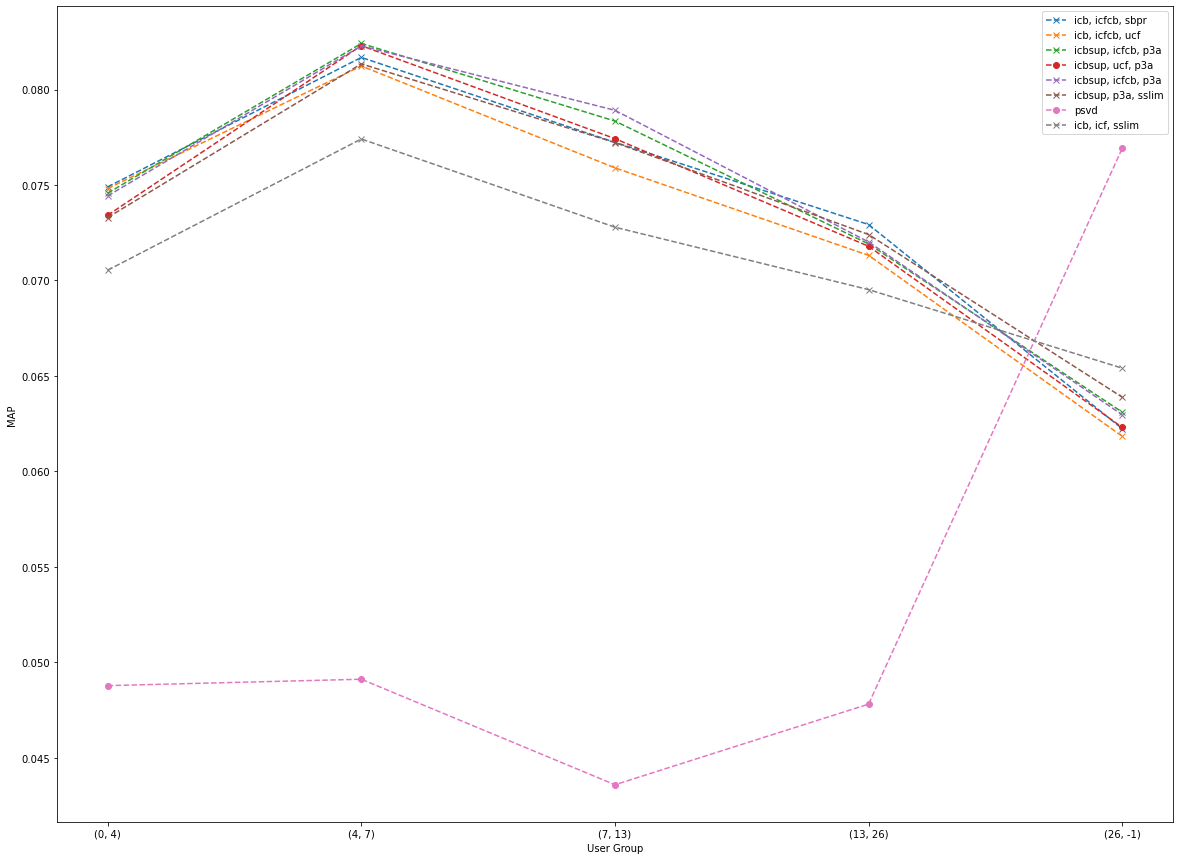

In [10]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(20,15))
for key in to_be_plotted:
    l=[]
    for result_dict in MAP_per_group:
        l.append(result_dict[key])
    if np.random.random() > 0.5:
        style = '--o'
    else:
        style = '--x'
    label = recommenders[key][0]
    """
    else:
        for merged_dict in MAP_merged_per_group:
            l.append(merged_dict[key])
        style = '--x'
        label = merged_labels[key]
        """
    pyplot.plot(l, style, label = label)

pyplot.xticks(ticks=range(0,len(f_ranges)), labels=f_ranges)
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()